In [ ]:
# -*- coding: utf-8 -*-
# 文件名: solve_problem_3_final.py
# 功能: 问题三最终求解代码，集成了经过验证的数据加载逻辑和高级模拟功能。

import pandas as pd
import numpy as np
import os
import re
import random
import copy
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import multiprocessing

# --- 1. 【核心配置区】 ---

# --- CPU核心数设置 ---
# 设置为 0 或 None 时，将自动使用所有可用的CPU核心
NUM_CORES = 0 

# --- 算法参数 ---
POP_SIZE_PER_SUBPOP = 50
NUM_POPULATIONS = 5
MAX_GEN = 200
CX_PROB = 0.8
MUT_PROB = 0.2
MIGRATION_INTERVAL = 25
MIGRATION_SIZE = 3
ELITISM_SIZE = 2  # 保留每代最优个体数量，可根据需要调整

# --- 问题三特定参数 ---
NUM_SCENARIOS = 100 
YEARS = list(range(2024, 2031))

# [P3] 定义相关性和替代性参数
CORR_MATRIX = np.array([
    [1.0, 0.2, 0.1, 0.1, 0.1], [0.2, 1.0, 0.1, 0.1, 0.1],
    [0.1, 0.1, 1.0, 0.6, 0.2], [0.1, 0.1, 0.6, 1.0, 0.2],
    [0.1, 0.1, 0.2, 0.2, 1.0]
])
RANDOM_VAR_NAMES = ['小麦_price', '玉米_price', '番茄_price', '黄瓜_price', 'cost_factor']
CROSS_ELASTICITY = {
    '番茄': {'黄瓜': 0.5, '茄子': 0.4}, '黄瓜': {'番茄': 0.5, '茄子': 0.3},
    '茄子': {'番茄': 0.4, '黄瓜': 0.3}, '辣椒': {'茄子': 0.3}
}


# --- 2. 数据加载与情景生成 ---

def load_and_prepare_data(data_path):
    """
    数据加载函数，此版本严格沿用您提供的、已被验证的版本。
    """
    try:
        path_f1 = data_path / '附件1.xlsx'
        path_f2 = data_path / '附件2.xlsx'
        plots_df = pd.read_excel(path_f1, sheet_name='乡村的现有耕地')
        crops_info_df = pd.read_excel(path_f1, sheet_name='乡村种植的农作物')
        stats_df = pd.read_excel(path_f2, sheet_name='2023年统计的相关数据')
        past_planting_df = pd.read_excel(path_f2, sheet_name='2023年的农作物种植情况')
        for df in [plots_df, crops_info_df, stats_df, past_planting_df]:
            df.columns = df.columns.str.strip()
        params = {}
        params['I_plots'] = sorted(plots_df['地块名称'].tolist())
        params['P_area'] = dict(zip(plots_df['地块名称'], plots_df['地块面积/亩']))
        params['P_plot_type'] = dict(zip(plots_df['地块名称'], plots_df['地块类型']))
        params['J_crops'] = sorted(crops_info_df['作物名称'].dropna().unique().tolist())
        params['P_crop_type'] = dict(zip(crops_info_df['作物名称'], crops_info_df['作物类型']))
        params['J_bean'] = [j for j, ctype in params['P_crop_type'].items() if isinstance(ctype, str) and '豆' in ctype]
        params['J_grain'] = [j for j, ctype in params['P_crop_type'].items() if '粮食' in str(ctype)]
        params['J_vegetable'] = [j for j, ctype in params['P_crop_type'].items() if '蔬菜' in str(ctype)]
        params['J_fungus'] = [j for j, ctype in params['P_crop_type'].items() if '食用菌' in str(ctype)]
        params['P_past'] = {i: {1: None, 2: None} for i in params['I_plots']}
        for _, row in past_planting_df.iterrows():
            plot, crop, season = row['种植地块'], row['作物名称'], row.get('种植季节', 1)
            if plot in params['I_plots']:
                params['P_past'][plot][season] = crop
        def clean_and_convert_price(value):
            if isinstance(value, str) and any(c in value for c in '-–—'):
                parts = re.split(r'[-–—]', value.strip())
                try: return (float(parts[0]) + float(parts[1])) / 2
                except (ValueError, IndexError): return np.nan
            return pd.to_numeric(value, errors='coerce')
        stats_df['销售单价/(元/斤)'] = stats_df['销售单价/(元/斤)'].apply(clean_and_convert_price)
        stats_df.dropna(subset=['亩产量/斤', '种植成本/(元/亩)', '销售单价/(元/斤)'], inplace=True)
        params['P_yield_base'], params['P_cost_base'], params['P_price_base'] = {}, {}, {}
        for _, row in stats_df.iterrows():
            key = (row['作物名称'], row['地块类型'])
            params['P_cost_base'][key] = row['种植成本/(元/亩)']
            params['P_yield_base'][key] = row['亩产量/斤']
            params['P_price_base'][key] = row['销售单价/(元/斤)']
        params['P_demand_base'] = {j: 0 for j in params['J_crops']}
        merged_df = pd.merge(past_planting_df, plots_df, left_on='种植地块', right_on='地块名称', how='left')
        for crop in params['J_crops']:
            crop_plantings = merged_df[merged_df['作物名称'] == crop]
            total_yield = 0
            if not crop_plantings.empty:
                for _, row in crop_plantings.iterrows():
                    area = row.get('种植面积/亩', params['P_area'][row['种植地块']])
                    yield_val = params['P_yield_base'].get((crop, row['地块类型']), 0)
                    total_yield += area * yield_val
            if total_yield == 0: total_yield = 1000 
            params['P_demand_base'][crop] = total_yield
        params['S_suitability'] = defaultdict(int)
        for i in params['I_plots']:
            plot_t = params['P_plot_type'].get(i, '')
            for j in params['J_crops']:
                crop_t = params['P_crop_type'].get(j, '')
                is_veg = '蔬菜' in str(crop_t)
                for k in [1, 2]:
                    suitable = 0
                    if plot_t in ['平旱地', '梯田', '山坡地'] and ('粮食' in str(crop_t) or j in params['J_bean']) and k == 1: suitable = 1
                    elif plot_t == '水浇地':
                        if '水稻' in j and k == 1: suitable = 1
                        elif is_veg and (k == 1 or k == 2): suitable = 1
                    elif plot_t == '普通大棚':
                        if is_veg and k == 1: suitable = 1
                        elif '食用菌' in str(crop_t) and k == 2: suitable = 1
                    elif plot_t == '智慧大棚' and is_veg and (k == 1 or k == 2): suitable = 1
                    params['S_suitability'][(i, j, k)] = suitable
        return params
    except Exception as e:
        print(f"错误: 加载数据失败: {e}"); raise

class ScenarioGenerator:
    def __init__(self, base_params):
        self.base_params = base_params
        self.cholesky_L = np.linalg.cholesky(CORR_MATRIX)
        self.var_map = {name: i for i, name in enumerate(RANDOM_VAR_NAMES)}

    def generate_one_scenario(self):
        scenario = { 'yield': defaultdict(dict), 'cost': defaultdict(dict), 'price': defaultdict(dict), 'demand': defaultdict(dict) }
        corr_randoms = (self.cholesky_L @ np.random.normal(0, 1, size=(len(RANDOM_VAR_NAMES), len(YEARS)))).T
        for t_idx, year in enumerate(YEARS):
            cost_growth = (1.05) ** (t_idx + 1)
            cost_perturb = corr_randoms[t_idx, self.var_map['cost_factor']] * 0.02
            for key, base_yield in self.base_params['P_yield_base'].items():
                scenario['yield'][year][key] = base_yield * (1 + np.random.uniform(-0.1, 0.1))
            for key, base_cost in self.base_params['P_cost_base'].items():
                scenario['cost'][year][key] = base_cost * cost_growth * (1 + cost_perturb)
            for key, base_price in self.base_params['P_price_base'].items():
                crop, plot_type = key
                price_factor = 1.0
                if crop in self.base_params['J_grain']: price_factor = 1.0
                elif crop in self.base_params['J_vegetable']:
                    price_growth, p_perturb = (1.05) ** (t_idx + 1), 0
                    if f"{crop}_price" in self.var_map: p_perturb = corr_randoms[t_idx, self.var_map[f"{crop}_price"]] * 0.05
                    price_factor = price_growth * (1 + p_perturb)
                elif crop in self.base_params['J_fungus']:
                    decrease_rate = 0.05 if crop == '羊肚菌' else np.random.uniform(0.01, 0.05)
                    price_factor = (1 - decrease_rate) ** (t_idx + 1)
                scenario['price'][year][key] = base_price * price_factor
            for crop, base_demand in self.base_params['P_demand_base'].items():
                demand_factor = (1 + np.random.uniform(0.05, 0.1))**(t_idx + 1) if crop in ['小麦', '玉米'] else 1 + np.random.uniform(-0.05, 0.05)
                scenario['demand'][year][crop] = base_demand * demand_factor
        for year in YEARS:
            price_changes = {}
            for crop in self.base_params['J_crops']:
                key = (crop, '平旱地')
                p_new, p_base = scenario['price'][year].get(key, 0), self.base_params['P_price_base'].get(key, 1)
                price_changes[crop] = (p_new - p_base) / p_base
            adjusted_demand = scenario['demand'][year].copy()
            for crop_a, rivals in CROSS_ELASTICITY.items():
                if crop_a in adjusted_demand:
                    demand_change_factor = sum(elasticity * price_changes.get(crop_b, 0) for crop_b, elasticity in rivals.items())
                    adjusted_demand[crop_a] *= (1 + demand_change_factor)
            scenario['demand'][year] = adjusted_demand
        return scenario

    def generate_scenarios(self, num_scenarios):
        print(f"（2）[P3] 正在生成 {num_scenarios} 个高级情景...")
        return [self.generate_one_scenario() for _ in tqdm(range(num_scenarios), desc="生成情景")]

# --- 3. 遗传算法核心函数 ---
def create_initial_solution(params):
    solution = {y: {k: {i: None for i in params['I_plots']} for k in [1, 2]} for y in YEARS}
    for y in YEARS:
        for i in params['I_plots']:
            for k in [1, 2]:
                possible_crops = [j for j in params['J_crops'] if params['S_suitability'].get((i, j, k), 0) == 1]
                if possible_crops:
                    solution[y][k][i] = random.choice(possible_crops)
    return repair_solution(solution, params)

def repair_solution(solution, params):
    def get_crops_in_year(sol, y, i):
        crops = set()
        if y == 2023:
            for k in [1, 2]:
                crop = params['P_past'].get(i, {}).get(k)
                if crop: crops.add(crop)
        elif y in sol:
            for k in [1, 2]:
                crop = sol.get(y, {}).get(k, {}).get(i)
                if crop: crops.add(crop)
        return list(crops)
    for i in params['I_plots']:
        for y in YEARS:
            crops_last_year = get_crops_in_year(solution, y - 1, i)
            for k in [1, 2]:
                crop_this_season = solution[y][k][i]
                if crop_this_season and crop_this_season in crops_last_year:
                    possible_replacements = [j for j in params['J_crops'] if params['S_suitability'].get((i, j, k), 0) == 1 and j not in crops_last_year]
                    solution[y][k][i] = random.choice(possible_replacements) if possible_replacements else None
    for i in params['I_plots']:
        all_years_with_past = [2023] + YEARS
        for idx in range(len(all_years_with_past) - 2):
            window = all_years_with_past[idx:idx+3]
            contains_bean = any(c in params['J_bean'] for y_win in window for c in get_crops_in_year(solution, y_win, i))
            if not contains_bean:
                y_fix = random.choice([y for y in window if y > 2023])
                k_fix = 1
                crops_last_year = get_crops_in_year(solution, y_fix - 1, i)
                possible_beans = [b for b in params['J_bean'] if params['S_suitability'].get((i, b, k_fix), 0) == 1 and b not in crops_last_year]
                if possible_beans:
                    solution[y_fix][k_fix][i] = random.choice(possible_beans)
    return solution

def crossover(p1, p2, params):
    child = copy.deepcopy(p1)
    for i in params['I_plots']:
        if random.random() < 0.5:
            for y in YEARS:
                for k in [1, 2]:
                    child[y][k][i] = p2[y][k][i]
    return child

def mutate(solution, params):
    mut_sol = copy.deepcopy(solution)
    for _ in range(random.randint(1, 5)):
        y, i, k = random.choice(YEARS), random.choice(params['I_plots']), random.choice([1, 2])
        possible_crops = [j for j in params['J_crops'] if params['S_suitability'].get((i, j, k), 0) == 1]
        if possible_crops:
            mut_sol[y][k][i] = random.choice(possible_crops)
    return mut_sol

def calculate_profits_for_solution(solution, params, scenarios):
    profits = []
    for scenario in scenarios:
        total_revenue, total_cost = 0, 0
        total_production_by_crop = defaultdict(float)
        for y in YEARS:
            for i in params['I_plots']:
                plot_type, area = params['P_plot_type'][i], params['P_area'][i]
                for k in [1, 2]:
                    crop = solution[y][k].get(i)
                    if not crop: continue
                    key = (crop, plot_type)
                    cost = scenario['cost'][y].get(key, 9e9)
                    yield_val = scenario['yield'][y].get(key, 0)
                    if cost > 1e9: continue
                    total_cost += area * cost
                    total_production_by_crop[crop] += area * yield_val
        for crop, production in total_production_by_crop.items():
            total_demand_7_years = sum(scenario['demand'][y].get(crop, 0) for y in YEARS)
            all_prices = [p for y_prices in scenario['price'].values() for (c, pt), p in y_prices.items() if c == crop and p > 0]
            price = np.mean(all_prices) if all_prices else 0
            if price > 0:
                normal_qty = min(production, total_demand_7_years)
                total_revenue += (normal_qty * price) + ((production - normal_qty) * price * 0.5)
        profits.append(total_revenue - total_cost)
    return profits

def evaluate_fitness_p3(solution, params, scenarios):
    profits = calculate_profits_for_solution(solution, params, scenarios)
    valid_profits = [p for p in profits if not np.isnan(p)]
    if not valid_profits: return -1e12
    return np.mean(valid_profits)

def evaluate_fitness_wrapper(args):
    return evaluate_fitness_p3(*args)

# --- 4. MPGA 运行器 ---
def run_mpga(params, scenarios, pool):
    print(f"\n--- (3) 开始执行MPGA ---")
    populations = [[create_initial_solution(params) for _ in range(POP_SIZE_PER_SUBPOP)] for _ in range(NUM_POPULATIONS)]
    best_solution_overall, best_fitness_overall = None, -np.inf
    
    for gen in tqdm(range(MAX_GEN), desc="MPGA进化中"):
        all_fitnesses = []
        for i in range(NUM_POPULATIONS):
            pop = populations[i]
            task_args = [(sol, params, scenarios) for sol in pop]
            fitnesses = pool.starmap(evaluate_fitness_wrapper, task_args)
            all_fitnesses.append(fitnesses)
            best_fit_in_pop = np.max(fitnesses)
            if best_fit_in_pop > best_fitness_overall:
                best_fitness_overall = best_fit_in_pop
                best_solution_overall = copy.deepcopy(pop[np.argmax(fitnesses)])
            
            elite_indices = np.argsort(fitnesses)[-ELITISM_SIZE:]
            new_pop = [pop[idx] for idx in elite_indices]
            
            while len(new_pop) < POP_SIZE_PER_SUBPOP:
                def tournament_selection(p, f, k=3):
                    best_idx = random.randrange(len(p))
                    for _ in range(k - 1):
                        idx = random.randrange(len(p))
                        if f[idx] > f[best_idx]: best_idx = idx
                    return p[best_idx]
                p1, p2 = tournament_selection(pop, fitnesses), tournament_selection(pop, fitnesses)
                child = crossover(p1, p2, params) if random.random() < CX_PROB else copy.deepcopy(p1)
                if random.random() < MUT_PROB: child = mutate(child, params)
                new_pop.append(repair_solution(child, params))
            populations[i] = new_pop
        
        if gen > 0 and gen % MIGRATION_INTERVAL == 0:
            for i in range(NUM_POPULATIONS):
                target_pop_idx = (i + 1) % NUM_POPULATIONS
                best_indices_current = np.argsort(all_fitnesses[i])[-MIGRATION_SIZE:]
                migrants = [populations[i][idx] for idx in best_indices_current]
                worst_indices_target = np.argsort(all_fitnesses[target_pop_idx])[:MIGRATION_SIZE]
                for j in range(MIGRATION_SIZE):
                    populations[target_pop_idx][worst_indices_target[j]] = copy.deepcopy(migrants[j])
    
    print(f"\n--- MPGA 优化完成 ---")
    return best_solution_overall, best_fitness_overall

# --- 5. 主程序入口 ---
if __name__ == '__main__':
    # This setup is required for multiprocessing to work correctly, especially on Windows/MacOS
    multiprocessing.freeze_support()

    num_cores_to_use = NUM_CORES if NUM_CORES and NUM_CORES > 0 else multiprocessing.cpu_count()
    print(f"--- 检测到 {multiprocessing.cpu_count()} 个CPU核心，将启动 {num_cores_to_use} 个进程 ---")
    
    with multiprocessing.Pool(processes=num_cores_to_use) as pool:
        try:
            project_dir = Path.cwd()
            data_path = project_dir / '..'/'Data'
            output_dir = project_dir / 'Result'
            output_dir.mkdir(parents=True, exist_ok=True)
            
            print(f"--- 问题三 MPGA 求解启动 (最终版) ---")
            print(f"数据读取路径: {data_path.resolve()}")
            print(f"结果输出路径: {output_dir.resolve()}")
            
            print("\n（1）加载基础数据...")
            base_params = load_and_prepare_data(data_path)
            print(" -> 基础数据加载成功。")
            
            scenario_generator = ScenarioGenerator(base_params)
            scenarios = scenario_generator.generate_scenarios(NUM_SCENARIOS)
            print(" -> 高级情景生成成功。")
            
            best_solution, best_fitness = run_mpga(base_params, scenarios, pool)
            
            print(f"\n求解完成。")
            print(f" -> 最优方案预期平均利润: {best_fitness:,.2f} 元")

            if best_solution:
                output_list = []
                for y in sorted(best_solution.keys()):
                    for k in sorted(best_solution[y].keys()):
                        for i in sorted(best_solution[y][k].keys()):
                            crop = best_solution[y][k][i]
                            if crop:
                                output_list.append({'年份': y, '季节': k, '地块编号': i, '作物名称': crop, '种植面积（亩）': base_params['P_area'][i]})
                result_df = pd.DataFrame(output_list)
                file_path = output_dir / '问题三最优种植策略.xlsx'
                result_df.to_excel(file_path, index=False)
                print(f"最优方案已保存至: {file_path}")
            else:
                print("未能找到有效解。")

        except FileNotFoundError:
            print(f"\n错误：文件未找到。请检查您的项目文件夹内是否包含 'Data' 子文件夹，且附件1和2在其中。")
            print(f"程序查找的路径是: {data_path.resolve()}")
        except Exception as e:
            print(f"\n程序主流程发生严重错误: {e}")
            import traceback
            traceback.print_exc()

--- 检测到 16 个CPU核心，将启动 16 个进程 ---
--- 问题三 MPGA 求解启动 (最终版) ---
数据读取路径: C:\Users\86185\Desktop\2024C\Data
结果输出路径: C:\Users\86185\Desktop\2024C\5问题三\Result

（1）加载基础数据...
 -> 基础数据加载成功。
（2）[P3] 正在生成 100 个高级情景...


生成情景: 100%|██████████| 100/100 [00:00<00:00, 284.65it/s]


 -> 高级情景生成成功。

--- (3) 开始执行MPGA ---


MPGA进化中:   0%|          | 0/200 [00:00<?, ?it/s]

正在从 c:\Users\86185\Desktop\2024C\5问题三\Problem3_MPGA_Results\最优种植策略_MPGA.xlsx 加载数据...


C:\Users\86185\AppData\Local\Temp\ipykernel_4236\592958267.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_crops))


图像已保存至: c:\Users\86185\Desktop\2024C\5问题三\Problem3_MPGA_Results\最优策略种植时间图.png


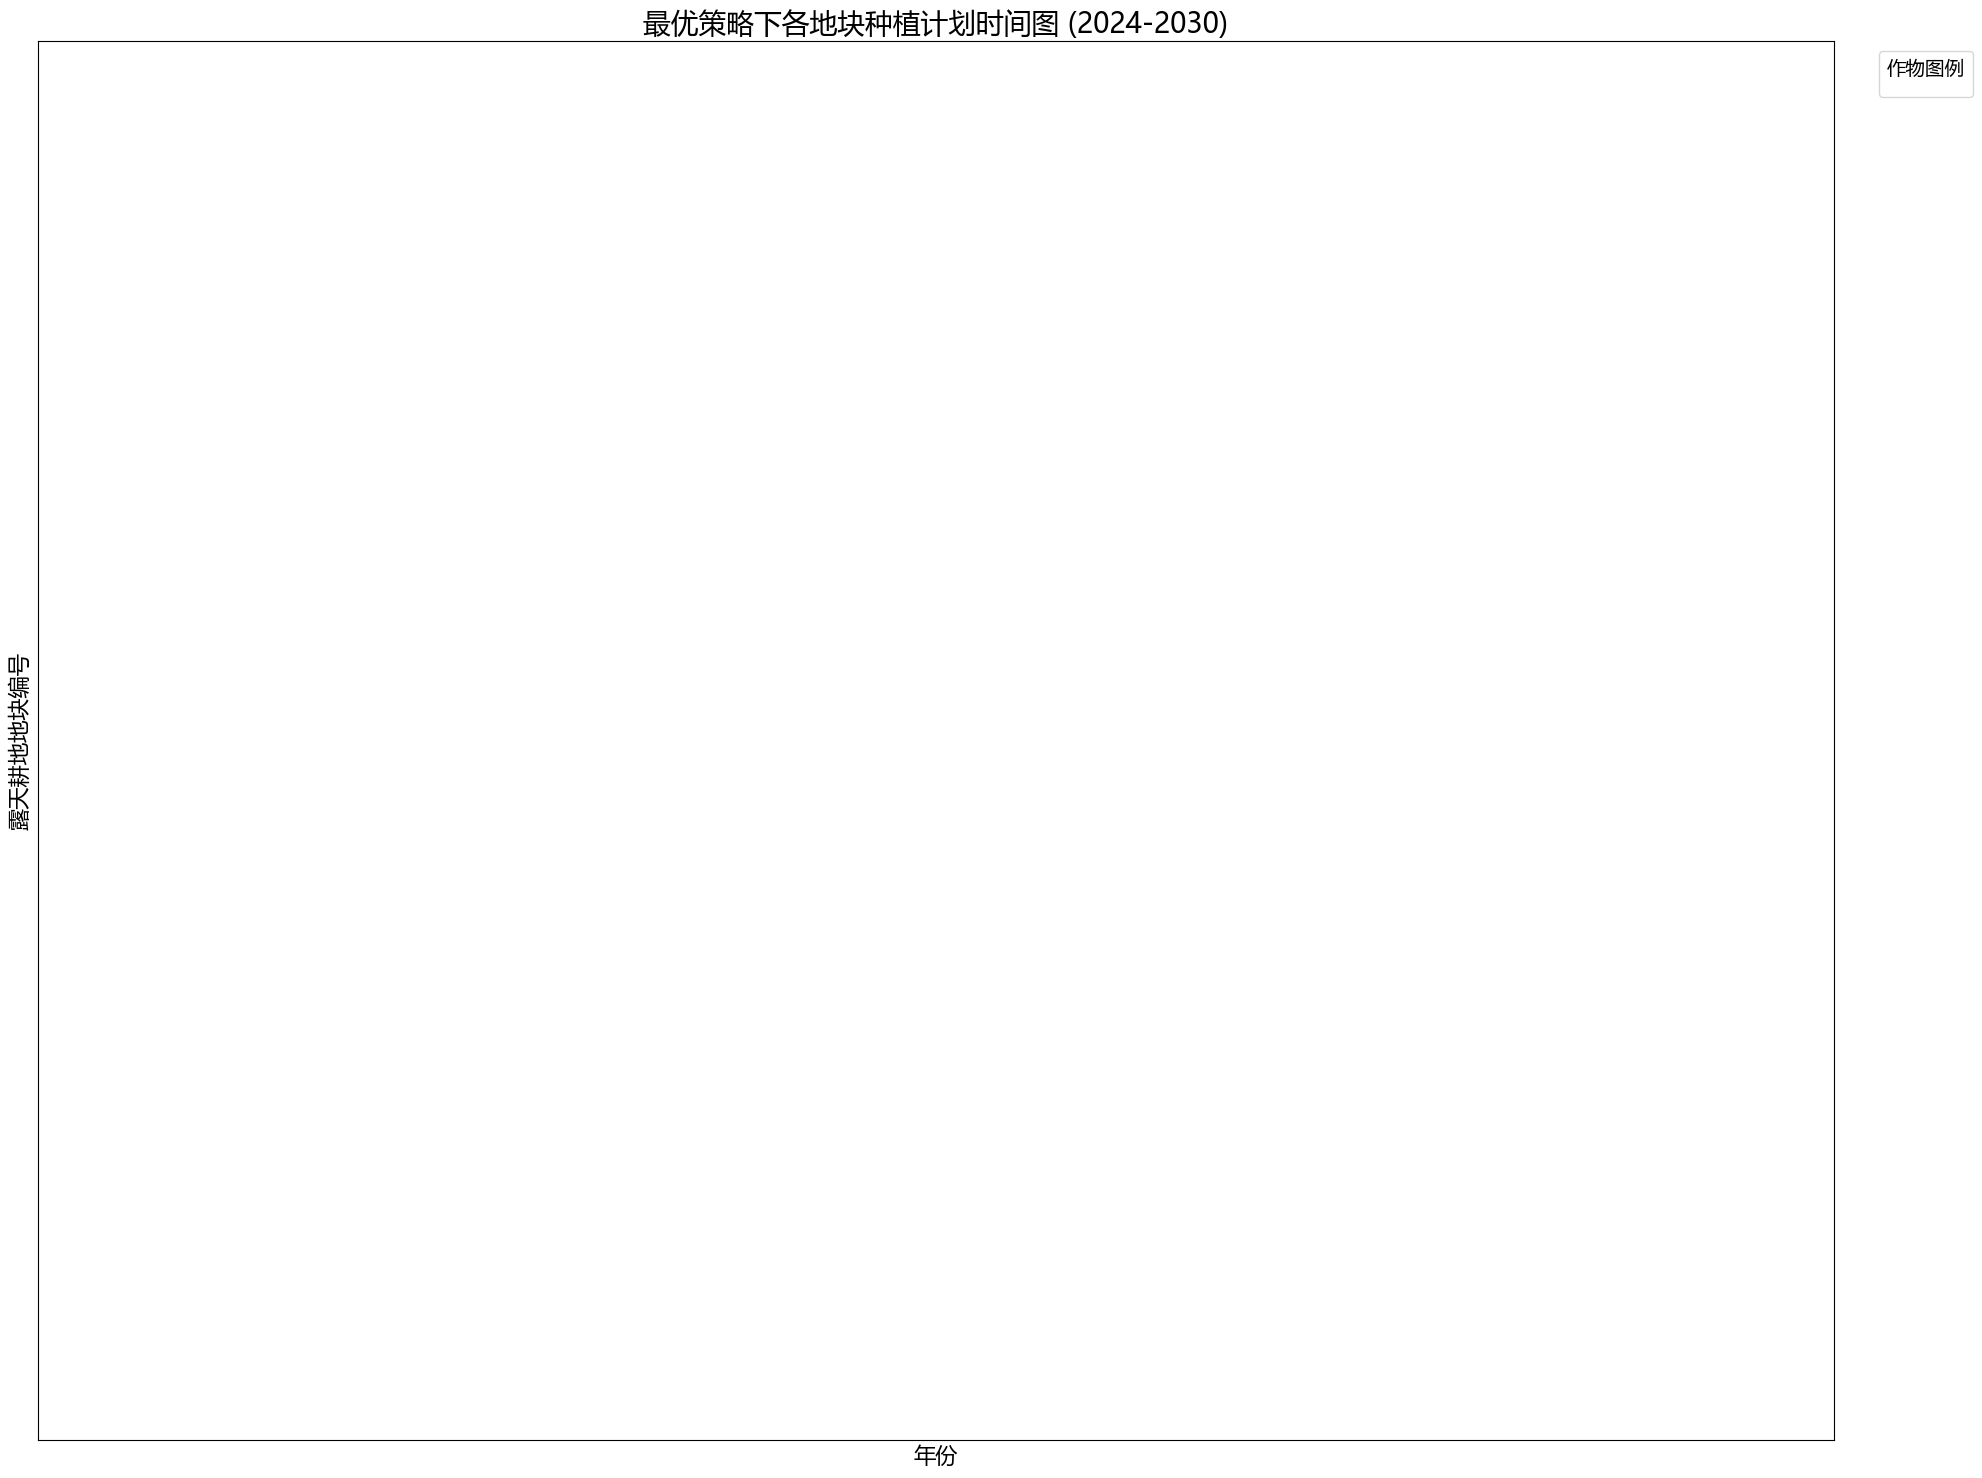

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# --- 绘图配置 ---
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16

# --- 数据加载 ---
output_dir = Path.cwd() / 'Problem3_MPGA_Results'
result_file = output_dir / '最优种植策略_MPGA.xlsx'

if not result_file.exists():
    print(f"错误：无法找到结果文件 {result_file}")
    print("请先完整运行 solve_problem3_mpga.py 脚本以生成结果文件。")
else:
    print(f"正在从 {result_file} 加载数据...")
    df = pd.read_excel(result_file)

    # --- 数据处理 ---
    # 筛选露天耕地用于可视化，大棚地块较少，单独分析
    df_plots = df[df['地块编号'].str.startswith('P')].copy()
    
    # 创建一个适合热力图的数据透视表
    # 将季节信息合并到作物名称中以便区分
    df_plots['作物季节'] = df_plots['种植作物'] + '(' + df_plots['季节'].astype(str) + '季)'
    
    # 创建一个从作物名称到颜色的映射
    unique_crops = sorted(df_plots['种植作物'].unique())
    colors = plt.cm.get_cmap('tab20', len(unique_crops))
    crop_to_color = {crop: colors(i) for i, crop in enumerate(unique_crops)}
    
    # --- 绘图 ---
    fig, ax = plt.subplots(figsize=(20, 15))

    # Y轴是地块，X轴是年份
    y_ticks = sorted(df_plots['地块编号'].unique())
    y_tick_pos = np.arange(len(y_ticks))
    
    for i, plot_name in enumerate(y_ticks):
        plot_df = df_plots[df_plots['地块编号'] == plot_name]
        for _, row in plot_df.iterrows():
            year = row['年份']
            season = row['季节']
            crop = row['种植作物']
            
            # 用不同宽度的条形代表不同季节
            if season == 1:
                ax.barh(y=i, width=0.8, left=year - 0.4, height=0.6, 
                        color=crop_to_color[crop], edgecolor='black', label=crop)
            else: # 第2季
                ax.barh(y=i, width=0.2, left=year + 0.2, height=0.8, 
                        color=crop_to_color[crop], edgecolor='grey', hatch='//')

    ax.set_yticks(y_tick_pos)
    ax.set_yticklabels(y_ticks)
    ax.set_xticks(sorted(df_plots['年份'].unique()))
    ax.set_xlabel('年份')
    ax.set_ylabel('露天耕地地块编号')
    ax.set_title('最优策略下各地块种植计划时间图 (2024-2030)')
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # 创建图例 (处理重复标签)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.02, 1), loc='upper left', title='作物图例')

    plt.tight_layout()
    
    # 保存图像
    output_image_path = output_dir / "最优策略种植时间图.png"
    plt.savefig(output_image_path, dpi=300)
    print(f"图像已保存至: {output_image_path}")
    plt.show()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- 绘图配置 ---
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16

# --- 数据加载 ---
output_dir = Path.cwd() / 'Problem3_MPGA_Results'
result_file = output_dir / '最优种植策略_MPGA.xlsx'
crops_info_file = Path.cwd() / '附件1.xlsx'


if not result_file.exists() or not crops_info_file.exists():
    print(f"错误：无法找到所需文件。")
    print(f"请确保 {result_file} 和 {crops_info_file} 存在。")
else:
    print(f"正在从 {result_file} 加载数据...")
    df = pd.read_excel(result_file)
    crops_info_df = pd.read_excel(crops_info_file, sheet_name='乡村种植的农作物')
    
    # --- 数据处理 ---
    # 清理列名
    crops_info_df.columns = crops_info_df.columns.str.strip()
    
    # 获取作物类型映射
    crop_to_type = dict(zip(crops_info_df['作物名称'], crops_info_df['作物类型']))
    
    df['作物类型'] = df['种植作物'].map(crop_to_type)
    
    # 按年份和作物类型汇总面积
    area_summary = df.groupby(['年份', '作物类型'])['种植面积'].sum().reset_index()
    
    # 转换为数据透视表以方便绘图
    pivot_df = area_summary.pivot(index='年份', columns='作物类型', values='种植面积').fillna(0)
    
    # --- 绘图 ---
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 使用堆叠面积图
    pivot_df.plot(kind='area', stacked=True, ax=ax, alpha=0.8)
    
    ax.set_title('各类型作物总种植面积年度趋势')
    ax.set_xlabel('年份')
    ax.set_ylabel('总种植面积 (亩)')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title='作物类型')
    plt.xticks(pivot_df.index) # 确保X轴年份显示正确
    
    plt.tight_layout()
    
    # 保存图像
    output_image_path = output_dir / "各类型作物总种植面积年度趋势图.png"
    plt.savefig(output_image_path, dpi=300)
    print(f"图像已保存至: {output_image_path}")
    plt.show()

错误：无法找到所需文件。
请确保 c:\Users\86185\Desktop\2024C\5问题三\Problem3_MPGA_Results\最优种植策略_MPGA.xlsx 和 c:\Users\86185\Desktop\2024C\5问题三\附件1.xlsx 存在。


正在从 c:\Users\86185\Desktop\2024C\5问题三\Problem3_MPGA_Results\最优种植策略_MPGA.xlsx 加载数据...
图像已保存至: c:\Users\86185\Desktop\2024C\5问题三\Problem3_MPGA_Results\主要作物总种植面积对比图.png


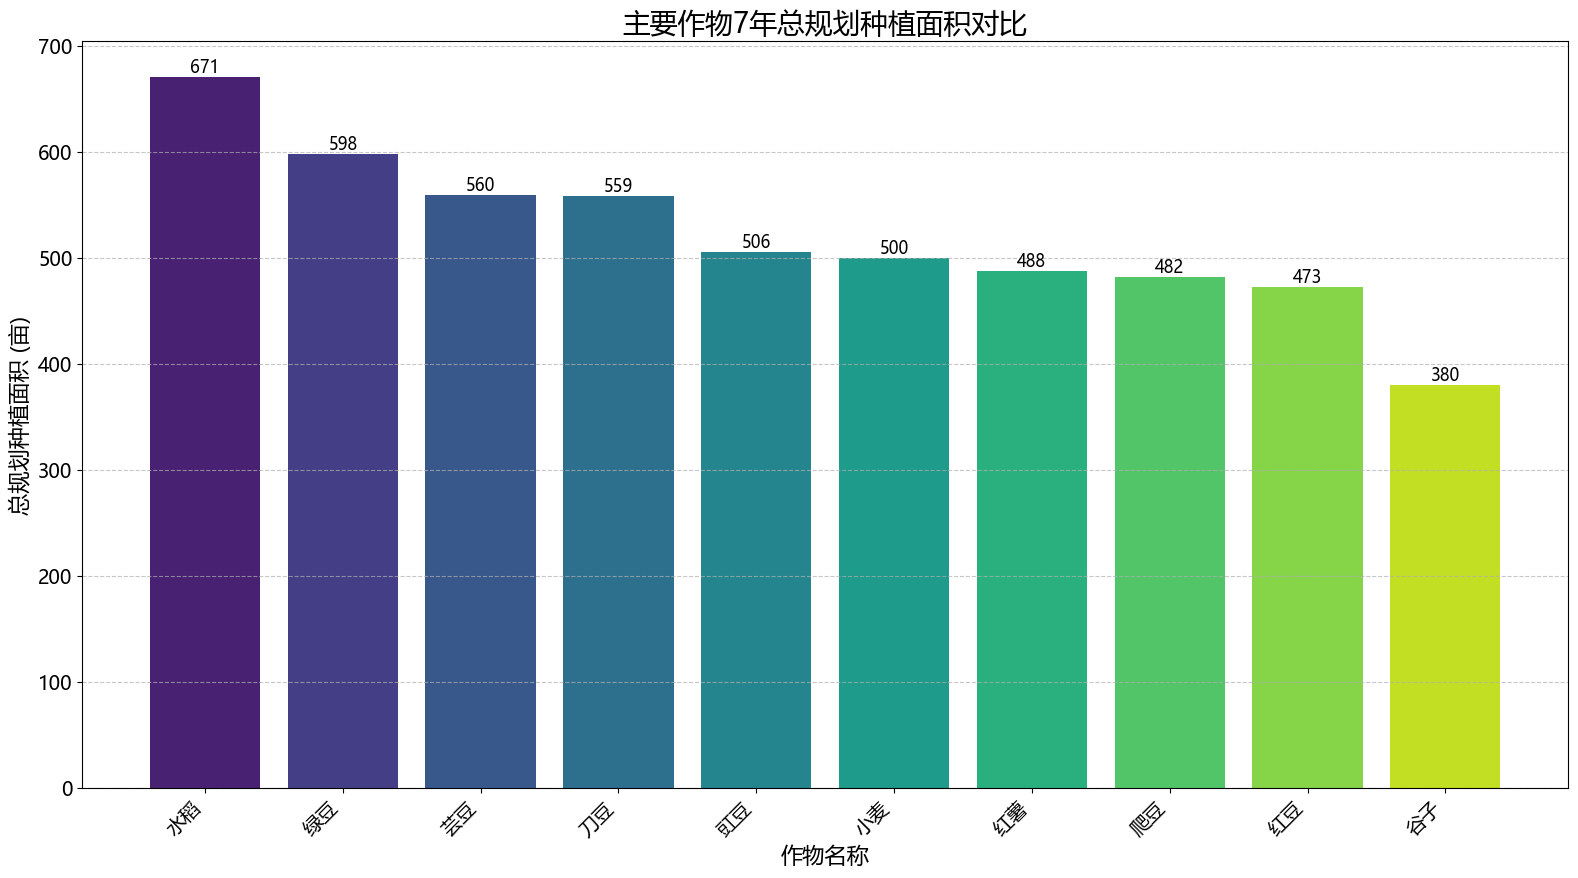

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- 绘图配置 ---
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16

# --- 数据加载 ---
output_dir = Path.cwd() / 'Problem3_MPGA_Results'
result_file = output_dir / '最优种植策略_MPGA.xlsx'

if not result_file.exists():
    print(f"错误：无法找到结果文件 {result_file}")
else:
    print(f"正在从 {result_file} 加载数据...")
    df = pd.read_excel(result_file)

    # --- 数据处理 ---
    # 计算每种作物在7年内的总种植面积（面积 * 种植次数）
    # 注意：这里的面积是地块面积，如果一个地块种了7年，总面积是 7 * 地块面积
    # 需要先按年份、地块、季节去重，因为同一地块一年可能报两次
    df_unique_plantings = df.drop_duplicates(subset=['年份', '地块编号', '季节'])
    total_area_by_crop = df_unique_plantings.groupby('种植作物')['种植面积'].sum().sort_values(ascending=False)
    
    # 选取种植面积最多的前10种作物进行展示
    top_crops_data = total_area_by_crop.head(10)

    # --- 绘图 ---
    plt.figure(figsize=(16, 9))
    
    # 使用高级感的配色方案
    colors = sns.color_palette("viridis", n_colors=len(top_crops_data))
    
    bars = plt.bar(top_crops_data.index, top_crops_data.values, color=colors)
    
    plt.title('主要作物7年总规划种植面积对比')
    plt.xlabel('作物名称')
    plt.ylabel('总规划种植面积 (亩)')
    plt.xticks(rotation=45, ha='right') # 旋转X轴标签以防重叠
    
    # 在条形图上显示数值
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:,.0f}', va='bottom', ha='center', fontsize=12)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # 保存图像
    output_image_path = output_dir / "主要作物总种植面积对比图.png"
    plt.savefig(output_image_path, dpi=300)
    print(f"图像已保存至: {output_image_path}")
    plt.show()